In [1]:
import sys

sys.path.append("../")

import MetaTrader5 as mt5
import pytz
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from datetime import datetime, timedelta
from terminal.Extensions.MT5 import MT5
from terminal.Extensions.Range import Range

In [2]:
MT5.initialize()

mt5.RES_E_NOT_FOUND

In [3]:
from_date = datetime(2024, 6, 18, hour=6, tzinfo=pytz.utc)
to_date = datetime(2024, 6, 19, tzinfo=pytz.utc)

trades_list = None

while from_date < to_date:
    trades = mt5.copy_ticks_range("WINQ24", from_date, from_date.replace(hour=23), mt5.COPY_TICKS_TRADE)
    if mt5.last_error()[0] == mt5.RES_S_OK and len(trades.shape) == 1:
        if trades_list is None:
            trades_list = trades
        else:
            trades_list = np.append(trades_list, trades)
    from_date += timedelta(days=1)
    del trades
    
all_trades = MT5.create_ticks_dataframe(trades_list)
all_trades

,bid,ask,last,volume,flags,volume_real
time_msc,,,,,,
2024-06-18 09:03:24.877,132975.0,108800.0,120550.0,700,56,700.0
2024-06-18 09:03:24.877,132975.0,108800.0,120550.0,100,56,100.0
2024-06-18 09:03:24.877,132975.0,108800.0,120550.0,150,56,150.0
2024-06-18 09:03:24.877,132975.0,108800.0,120550.0,250,56,250.0
2024-06-18 09:03:24.877,132975.0,108800.0,120550.0,250,56,250.0
...,...,...,...,...,...,...
2024-06-18 12:06:31.729,121335.0,121340.0,121340.0,3,56,3.0
2024-06-18 12:06:31.914,121335.0,121340.0,121335.0,1,88,1.0
2024-06-18 12:06:31.993,121335.0,121340.0,121335.0,1,88,1.0


In [29]:
brick_size = 30

trades_range = Range(
    brick_size, all_trades.index, all_trades["last"], all_trades["volume"]
)
ohlc = pd.DataFrame(trades_range.bricks)
ohlc.to_excel("bricks.xlsx")

In [30]:
def plot_chart():
    fig = go.Figure(
        data=go.Ohlc(
            open=ohlc["open"],
            high=ohlc["high"],
            low=ohlc["low"],
            close=ohlc["close"],
        )
    )

    fig.update(layout_xaxis_rangeslider_visible=False)

    fig.update_layout(
        autosize=True,
        width=1500,
        height=600,
    )

    return fig


plot_chart()

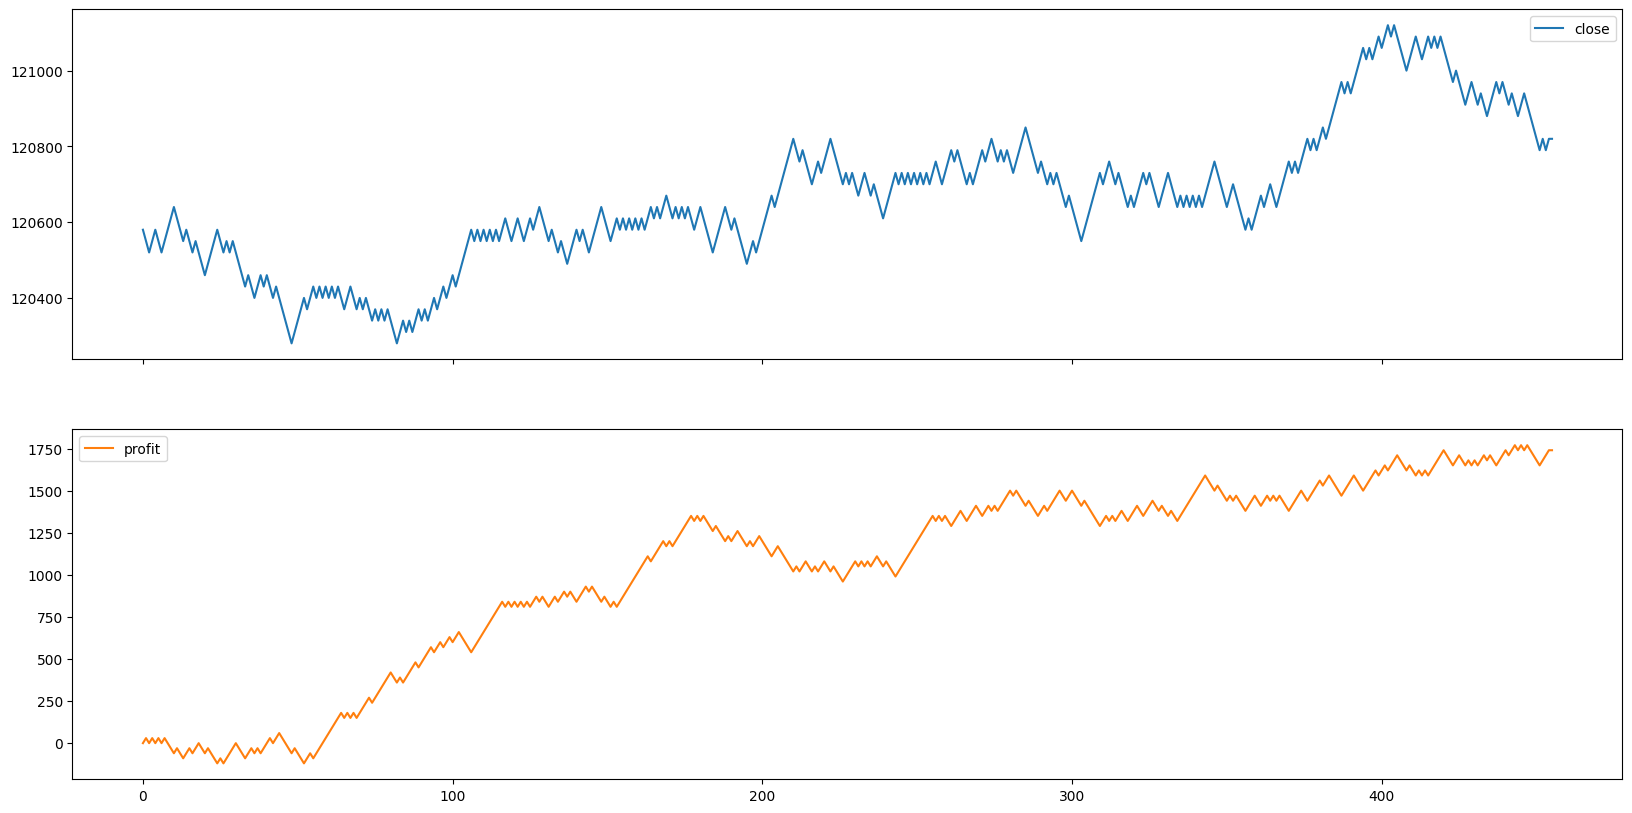

In [31]:
temp = ohlc.copy() 

temp["up_up"] = np.nan
temp["down_down"] = np.nan
temp["up_down"] = np.nan
temp["down_up"] = np.nan
temp["position_side"] = np.nan
temp["position"] = np.nan
temp["profit"] = np.nan

temp.loc[(temp["type"] == "up") & (temp.shift(-1)["type"] == "up"), "up_up"] = 1
temp.loc[(temp["type"] == "up") & (temp.shift(-1)["type"] == "down"), "up_down"] = 1
temp.loc[(temp["type"] == "down") & (temp.shift(-1)["type"] == "down"), "down_down"] = 1
temp.loc[(temp["type"] == "down") & (temp.shift(-1)["type"] == "up"), "down_up"] = 1

position_side = 0  # 1 = BUY, -1 = SELL

for i, item in temp.iterrows():
    if position_side == 0 and item["type"] == "down":  # buy
        temp.loc[i, "position"] = item["close"] * -1
        position_side = 1
    elif position_side == 0 and item["type"] == "up":  # sell
        temp.loc[i, "position"] = item["close"]
        position_side = -1
    elif position_side == -1 and item["type"] == "down":  # invert sell
        temp.loc[i, "position"] = item["close"] * 2 * -1
        position_side = 1
    elif position_side == 1 and item["type"] == "up":  # invert buy
        temp.loc[i, "position"] = item["close"] * 2
        position_side = -1

    temp.loc[i, "position_side"] = position_side
    temp.loc[i, "profit"] = temp.loc[:i]["position"].sum()

    if position_side == 1:
        temp.loc[i, "profit"] = temp.loc[i, "profit"] - temp.loc[i, "close"] * -1
    elif position_side == -1:
        temp.loc[i, "profit"] = temp.loc[i, "profit"] - temp.loc[i, "close"]

temp[["close", "profit"]].plot(figsize=(20, 10), subplots=[("close",), ("profit",)])
temp.to_excel("bricks.xlsx")